In [1]:
import json
import numpy as np
import os
import random
import re
import torch

from collections import Counter, defaultdict
from my_py_toolkit.file.file_toolkit import readjson, writejson, read_file, get_file_paths
from my_py_toolkit.data_visulization.matplotlib import plot_coh, plot_coh_dict
from my_py_toolkit.torch.transformers_pkg import bert_tokenize
from my_py_toolkit.ml.data.text_preprocess import tokenize_chinese
from torch.utils.data import IterableDataset, DataLoader


# duie 数据预处理

In [2]:
# 分析确定超参
max_len = 256 # 范围在 5~300， 256 包含绝大部分数据了, 实验的时候多试下这个参数, eg: 128, 300 等

In [17]:
# 参数
batch_size = 10
features_num = 1000
data_dir = '../resources/dataset/duie'
data_files = ['train_data.json', 'dev_data.json']
file_handled = 'duie_handled.json'
file_features = 'duie_features.json'
cache_dir = '../cache'
schemas_file = 'all_50_chemas'
bert_cfg = '../resources/bert_model/bert'
tags_path = os.path.join(data_dir, 'tags.json')
tokenizer = bert_tokenize(bert_cfg)

In [4]:
tags = readjson(tags_path)
tags_mapping = {tag:i for i, tag in enumerate(tags)}
tags_mapping

{'主演,人物,影视作品': 0,
 '目,目,生物': 1,
 '身高,Number,人物': 2,
 '出生日期,Date,人物': 3,
 '国籍,国家,人物': 4,
 '连载网站,网站,网络小说': 5,
 '作者,人物,图书作品': 6,
 '歌手,人物,歌曲': 7,
 '海拔,Number,地点': 8,
 '出生地,地点,人物': 9,
 '导演,人物,影视作品': 10,
 '气候,气候,行政区': 11,
 '朝代,Text,历史人物': 12,
 '妻子,人物,人物': 13,
 '丈夫,人物,人物': 14,
 '民族,Text,人物': 15,
 '毕业院校,学校,人物': 16,
 '编剧,人物,影视作品': 17,
 '出品公司,企业,影视作品': 18,
 '父亲,人物,人物': 19,
 '出版社,出版社,书籍': 20,
 '作词,人物,歌曲': 21,
 '作曲,人物,歌曲': 22,
 '母亲,人物,人物': 23,
 '成立日期,Date,企业': 24,
 '字,Text,历史人物': 25,
 '号,Text,历史人物': 26,
 '所属专辑,音乐专辑,歌曲': 27,
 '所在城市,城市,景点': 28,
 '总部地点,地点,企业': 29,
 '主持人,人物,电视综艺': 30,
 '上映时间,Date,影视作品': 31,
 '首都,城市,国家': 32,
 '成立日期,Date,机构': 33,
 '创始人,人物,企业': 34,
 '祖籍,地点,人物': 35,
 '改编自,作品,影视作品': 36,
 '制片人,人物,影视作品': 37,
 '注册资本,Number,企业': 38,
 '人口数量,Number,行政区': 39,
 '面积,Number,行政区': 40,
 '主角,人物,网络小说': 41,
 '占地面积,Number,机构': 42,
 '嘉宾,人物,电视综艺': 43,
 '简称,Text,机构': 44,
 '董事长,人物,企业': 45,
 '官方语言,语言,国家': 46,
 '邮政编码,Text,行政区': 47,
 '专业代码,Text,学科专业': 48,
 '修业年限,Number,学科专业': 49}

In [9]:
# 读取所有数据

def readdata(paths):
    datas = []
    for p in paths:
        for line in read_file(p, '\n'):
            if line:
                datas.append(json.loads(line))
    return datas

datas = readdata([os.path.join(data_dir, f) for f in data_files])
len(datas)



194609

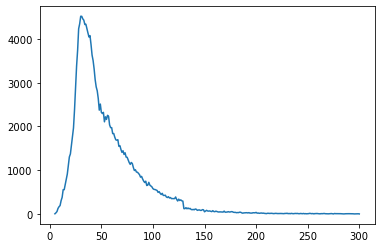

In [5]:
# 统计 text 的长度
len_counts = Counter([len(l['text']) for l in datas])
plot_coh_dict(len_counts)

In [6]:
sorted([(s, t) for s,t in len_counts.items()], key=lambda x:x[0])

[(5, 4),
 (6, 26),
 (7, 55),
 (8, 127),
 (9, 166),
 (10, 192),
 (11, 305),
 (12, 380),
 (13, 555),
 (14, 555),
 (15, 671),
 (16, 775),
 (17, 912),
 (18, 1116),
 (19, 1304),
 (20, 1373),
 (21, 1571),
 (22, 1765),
 (23, 1967),
 (24, 2380),
 (25, 2857),
 (26, 3381),
 (27, 3742),
 (28, 4235),
 (29, 4348),
 (30, 4521),
 (31, 4519),
 (32, 4462),
 (33, 4432),
 (34, 4332),
 (35, 4338),
 (36, 4235),
 (37, 4140),
 (38, 4047),
 (39, 4078),
 (40, 3874),
 (41, 3634),
 (42, 3509),
 (43, 3317),
 (44, 3072),
 (45, 2906),
 (46, 2817),
 (47, 2641),
 (48, 2374),
 (49, 2513),
 (50, 2324),
 (51, 2296),
 (52, 2323),
 (53, 2107),
 (54, 2221),
 (55, 2162),
 (56, 2256),
 (57, 2232),
 (58, 2036),
 (59, 1974),
 (60, 1974),
 (61, 1837),
 (62, 1839),
 (63, 1757),
 (64, 1696),
 (65, 1686),
 (66, 1698),
 (67, 1547),
 (68, 1560),
 (69, 1474),
 (70, 1408),
 (71, 1445),
 (72, 1361),
 (73, 1399),
 (74, 1301),
 (75, 1297),
 (76, 1235),
 (77, 1175),
 (78, 1133),
 (79, 1177),
 (80, 1154),
 (81, 1064),
 (82, 994),
 (83, 101

In [7]:
txt = '《其实我们很熟》是由陈奂仁作词、作曲，余文乐演唱的一首歌曲，收录于专辑《不是明星n.a.s.Ⅱ》中，发行于2011年04月13日'
reg = '不是明星N.A.S.ⅱ'
match = re.search(re.escape(reg), txt, re.I)
match, match.span()

(<_sre.SRE_Match object; span=(36, 47), match='不是明星n.a.s.Ⅱ'>, (36, 47))

Data label error: obj:胡抗美, sub:康里巎巎《杂诗》 txt:这本《康里巎巎杂诗(全彩色高清珍藏本)》(作者胡抗美)是其中一册
Data label error: obj:裸婚——80后的新结婚时代, sub:裸婚时代 txt:吴磊《沙海》《斗破苍穹》吴磊的《沙海》，除了吴磊 ，还有秦昊 、杨蓉、张萌、张铭恩、朱杰 等人主演的现代探险题材电视剧，该剧改编自南派三叔同名小说，普通高中生黎簇被卷入一个以世界现状为目的庞大计划中，然后认识了这一切的幕后布局者、以旅行摄影作家关根身份登场的吴邪的故事
Data label error: obj:王立群, sub:王立群读《史记》 txt:2008年1月24日上午9点半，央视“百家讲坛”栏目主讲人王立群将携《王立群读史记之 项羽 》在北京长城饭店召开新书首发会，欢迎有兴趣的读者到场参加
Data label error: obj:白发魔女传, sub:白发魔女传 txt:2010年9月，在《创:战纪》上映前，迪士尼曾聘请《无间行者》、《天国王朝》编剧威廉·莫纳汉为电影版改编剧本
Data label error: obj:15万平方米, sub:桂林国际会展中心 txt:概述桂林国际会展中心位于素有百里画廊之称的漓江之滨，是桂林市标志性建筑，占地面积 15 万平方米，建筑总面积 5
Data label error: obj:人民文学出版社, sub:《千字文》全解 txt:《千字文全解》是2009年人民文学出版社出版的图书，作者是李小龙
Data label error: obj:马银琴, sub:周秦时代《诗》的传播史 txt:周秦时代诗的传播史是社会科学文献出版社出版的，马银琴编写的图书
Data label error: obj:社会科学文献出版社, sub:周秦时代《诗》的传播史 txt:周秦时代诗的传播史是社会科学文献出版社出版的，马银琴编写的图书
Data label error: obj:山楂树之恋, sub:山楂树之恋 txt:《裸婚时代》改编自80后网络作家唐欣恬的小说《裸婚——80后的新结婚时代》，由北京光彩世纪文化艺术有限公司出品，导演滕华涛执导，文章首次担当编剧，文章、姚笛、张凯丽、丁嘉丽、韩童生、万茜等主演


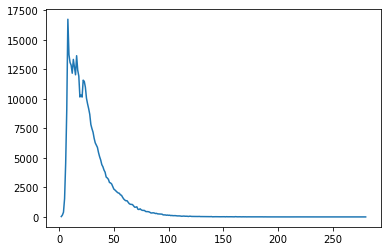

In [8]:
# 统计包含两个实体的最短 txt 的长度
minlen_txt = []
label_err_data = []
for data in datas:
    txt = data['text'].lower()
    for spo in data['spo_list']:
        obj = spo['object']
        sub = spo['subject']
        obj_match = re.search(re.escape(obj), txt, re.I)
        sub_match = re.search(re.escape(sub), txt, re.I)
        if not obj_match or not sub_match:
            print(f'Data label error: obj:{obj}, sub:{sub} txt:{txt}')
            label_err_data.append((obj, sub, txt))
            continue
        obj_s, obj_e = obj_match.span()
        sub_s, sub_e = sub_match.span()
        minlen_txt.append( max(obj_e, sub_e) - min(obj_s, sub_s))
minlen_txt = Counter(minlen_txt)
plot_coh_dict(minlen_txt)

In [9]:
# 看下 label 错误的两条数据
txt = ['吴磊《沙海》《斗破苍穹》吴磊的《沙海》，除了吴磊 ，还有秦昊 、杨蓉、张萌、张铭恩、朱杰 等人主演的现代探险题材电视剧，该剧改编自南派三叔同名小说，普通高中生黎簇被卷入一个以世界现状为目的庞大计划中，然后认识了这一切的幕后布局者、以旅行摄影作家关根身份登场的吴邪的故事', '《裸婚时代》改编自80后网络作家唐欣恬的小说《裸婚——80后的新结婚时代》，由北京光彩世纪文化艺术有限公司出品，导演滕华涛执导，文章首次担当编剧，文章、姚笛、张凯丽、丁嘉丽、韩童生、万茜等主演']
for data in datas:
    for t in txt:
        if t in data['text']:
            print(data)
            break
    


{'postag': [{'word': '吴磊', 'pos': 'nr'}, {'word': '《', 'pos': 'w'}, {'word': '沙海', 'pos': 'nw'}, {'word': '》', 'pos': 'w'}, {'word': '《', 'pos': 'w'}, {'word': '斗破苍穹', 'pos': 'nw'}, {'word': '》', 'pos': 'w'}, {'word': '吴磊', 'pos': 'nr'}, {'word': '的', 'pos': 'u'}, {'word': '《', 'pos': 'w'}, {'word': '沙海', 'pos': 'nw'}, {'word': '》', 'pos': 'w'}, {'word': '，', 'pos': 'w'}, {'word': '除了', 'pos': 'p'}, {'word': '吴磊', 'pos': 'nr'}, {'word': ' ', 'pos': 'w'}, {'word': '，', 'pos': 'w'}, {'word': '还有', 'pos': 'v'}, {'word': '秦昊', 'pos': 'nr'}, {'word': ' ', 'pos': 'w'}, {'word': '、', 'pos': 'w'}, {'word': '杨蓉', 'pos': 'nr'}, {'word': '、', 'pos': 'w'}, {'word': '张萌', 'pos': 'nr'}, {'word': '、', 'pos': 'w'}, {'word': '张铭恩', 'pos': 'nr'}, {'word': '、', 'pos': 'w'}, {'word': '朱杰', 'pos': 'nr'}, {'word': ' ', 'pos': 'w'}, {'word': '等人', 'pos': 'n'}, {'word': '主演', 'pos': 'v'}, {'word': '的', 'pos': 'u'}, {'word': '现代', 'pos': 't'}, {'word': '探险', 'pos': 'vn'}, {'word': '题材', 'pos': 'n'}, {'word': '

In [10]:
sorted([(k,v) for k,v in minlen_txt.items()], key=lambda x: x[0])

[(2, 32),
 (3, 155),
 (4, 399),
 (5, 1550),
 (6, 4542),
 (7, 9093),
 (8, 16753),
 (9, 13744),
 (10, 13092),
 (11, 12860),
 (12, 12178),
 (13, 13350),
 (14, 12720),
 (15, 12046),
 (16, 13663),
 (17, 12435),
 (18, 11931),
 (19, 10163),
 (20, 10332),
 (21, 10155),
 (22, 11590),
 (23, 11483),
 (24, 10993),
 (25, 10057),
 (26, 9580),
 (27, 9173),
 (28, 8695),
 (29, 7834),
 (30, 7478),
 (31, 7179),
 (32, 6667),
 (33, 6280),
 (34, 6081),
 (35, 5894),
 (36, 5452),
 (37, 5103),
 (38, 4823),
 (39, 4431),
 (40, 4255),
 (41, 3974),
 (42, 3791),
 (43, 3380),
 (44, 3302),
 (45, 3190),
 (46, 2920),
 (47, 2879),
 (48, 2790),
 (49, 2571),
 (50, 2360),
 (51, 2283),
 (52, 2191),
 (53, 2100),
 (54, 2031),
 (55, 2004),
 (56, 1874),
 (57, 1831),
 (58, 1666),
 (59, 1523),
 (60, 1433),
 (61, 1369),
 (62, 1378),
 (63, 1254),
 (64, 1129),
 (65, 1073),
 (66, 1062),
 (67, 1050),
 (68, 942),
 (69, 827),
 (70, 826),
 (71, 857),
 (72, 647),
 (73, 630),
 (74, 688),
 (75, 601),
 (76, 558),
 (77, 550),
 (78, 547),
 (79

In [11]:
# object, subject 在 text 找不到的数量
len(label_err_data)

9

In [12]:
# 处理完 object, subject 与 text 大小写对不上问题后
len(label_err_data)

9

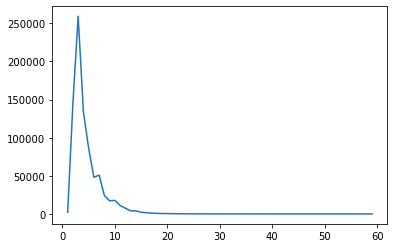

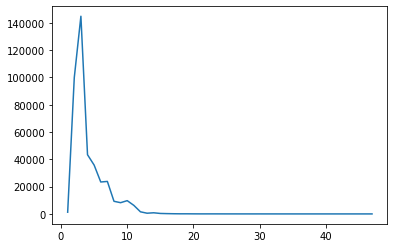

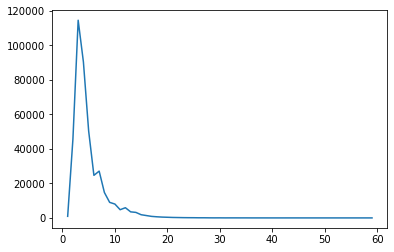

(None, None, None)

In [13]:
# 统计 object, subject 长度
len_obj = []
len_sub = []
len_objsub = []
for data in datas:
    for spo in data['spo_list']:
        len_obj.append(len(spo['object']))
        len_sub.append(len(spo['subject']))
len_objsub = len_obj + len_sub

len_obj = Counter(len_obj)
len_sub = Counter(len_sub)
len_objsub = Counter(len_objsub)
plot_coh_dict(len_objsub), plot_coh_dict(len_obj), plot_coh_dict(len_sub)

c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 19976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22827 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 29289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\dream\.conda\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: 

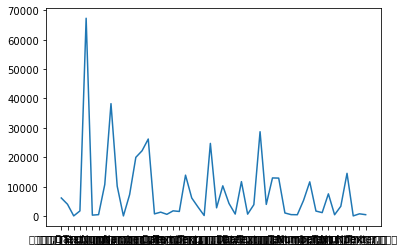

In [14]:
# 统计关系的数量
rel_count = defaultdict(int)
for data in datas:
    for spo in data['spo_list']:
        rel = ','.join([spo[k] for k in ['predicate', 'object_type', 'subject_type']])
        rel_count[rel] += 1

plot_coh_dict(rel_count)

In [15]:
sorted([(k, v) for k,v in rel_count.items()], key=lambda x: x[1], reverse=True)

[('主演,人物,影视作品', 67275),
 ('作者,人物,图书作品', 38217),
 ('歌手,人物,歌曲', 28667),
 ('出生日期,Date,人物', 26182),
 ('导演,人物,影视作品', 24694),
 ('出生地,地点,人物', 22182),
 ('出版社,出版社,书籍', 19955),
 ('连载网站,网站,网络小说', 14509),
 ('国籍,国家,人物', 13890),
 ('毕业院校,学校,人物', 12943),
 ('民族,Text,人物', 12888),
 ('所属专辑,音乐专辑,歌曲', 11685),
 ('目,目,生物', 11613),
 ('作曲,人物,歌曲', 10720),
 ('成立日期,Date,企业', 10261),
 ('作词,人物,歌曲', 10154),
 ('编剧,人物,影视作品', 7531),
 ('出品公司,企业,影视作品', 7266),
 ('妻子,人物,人物', 6124),
 ('丈夫,人物,人物', 6124),
 ('父亲,人物,人物', 5304),
 ('成立日期,Date,机构', 4253),
 ('上映时间,Date,影视作品', 3985),
 ('母亲,人物,人物', 3937),
 ('朝代,Text,历史人物', 3848),
 ('身高,Number,人物', 3298),
 ('字,Text,历史人物', 3072),
 ('总部地点,地点,企业', 2775),
 ('号,Text,历史人物', 1748),
 ('主持人,人物,电视综艺', 1719),
 ('祖籍,地点,人物', 1672),
 ('嘉宾,人物,电视综艺', 1539),
 ('制片人,人物,影视作品', 1304),
 ('简称,Text,机构', 1144),
 ('气候,气候,行政区', 1023),
 ('面积,Number,行政区', 736),
 ('创始人,人物,企业', 714),
 ('所在城市,城市,景点', 652),
 ('改编自,作品,影视作品', 624),
 ('占地面积,Number,机构', 563),
 ('注册资本,Number,企业', 460),
 ('人口数量,Number,行政区', 452),
 ('首都,城市,

In [16]:
[k for k in rel_count]

['主演,人物,影视作品',
 '目,目,生物',
 '身高,Number,人物',
 '出生日期,Date,人物',
 '国籍,国家,人物',
 '连载网站,网站,网络小说',
 '作者,人物,图书作品',
 '歌手,人物,歌曲',
 '海拔,Number,地点',
 '出生地,地点,人物',
 '导演,人物,影视作品',
 '气候,气候,行政区',
 '朝代,Text,历史人物',
 '妻子,人物,人物',
 '丈夫,人物,人物',
 '民族,Text,人物',
 '毕业院校,学校,人物',
 '编剧,人物,影视作品',
 '出品公司,企业,影视作品',
 '父亲,人物,人物',
 '出版社,出版社,书籍',
 '作词,人物,歌曲',
 '作曲,人物,歌曲',
 '母亲,人物,人物',
 '成立日期,Date,企业',
 '字,Text,历史人物',
 '号,Text,历史人物',
 '所属专辑,音乐专辑,歌曲',
 '所在城市,城市,景点',
 '总部地点,地点,企业',
 '主持人,人物,电视综艺',
 '上映时间,Date,影视作品',
 '首都,城市,国家',
 '成立日期,Date,机构',
 '创始人,人物,企业',
 '祖籍,地点,人物',
 '改编自,作品,影视作品',
 '制片人,人物,影视作品',
 '注册资本,Number,企业',
 '人口数量,Number,行政区',
 '面积,Number,行政区',
 '主角,人物,网络小说',
 '占地面积,Number,机构',
 '嘉宾,人物,电视综艺',
 '简称,Text,机构',
 '董事长,人物,企业',
 '官方语言,语言,国家',
 '邮政编码,Text,行政区',
 '专业代码,Text,学科专业',
 '修业年限,Number,学科专业']

In [5]:
tokenizer = bert_tokenize(bert_cfg)

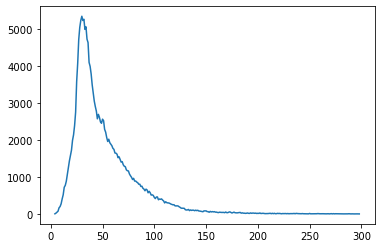

In [17]:
# 统计 token 长度

len_tokens = []
for data in datas:
    len_tokens.append(len(tokenize_chinese(tokenizer, data['text'])))
len_tokens = Counter(len_tokens)
plot_coh_dict(len_tokens)

In [18]:
sorted([(k, v) for k,v in len_tokens.items()], key=lambda x:x[0])

[(4, 4),
 (5, 22),
 (6, 49),
 (7, 74),
 (8, 166),
 (9, 201),
 (10, 274),
 (11, 407),
 (12, 519),
 (13, 722),
 (14, 773),
 (15, 886),
 (16, 1071),
 (17, 1258),
 (18, 1437),
 (19, 1580),
 (20, 1726),
 (21, 1990),
 (22, 2141),
 (23, 2391),
 (24, 2755),
 (25, 3580),
 (26, 4075),
 (27, 4717),
 (28, 5048),
 (29, 5238),
 (30, 5349),
 (31, 5234),
 (32, 5267),
 (33, 4994),
 (34, 5063),
 (35, 4729),
 (36, 4636),
 (37, 4099),
 (38, 3994),
 (39, 3787),
 (40, 3494),
 (41, 3277),
 (42, 3055),
 (43, 2908),
 (44, 2785),
 (45, 2574),
 (46, 2694),
 (47, 2613),
 (48, 2491),
 (49, 2453),
 (50, 2564),
 (51, 2524),
 (52, 2289),
 (53, 2214),
 (54, 2071),
 (55, 1961),
 (56, 2022),
 (57, 1928),
 (58, 1888),
 (59, 1847),
 (60, 1776),
 (61, 1748),
 (62, 1649),
 (63, 1644),
 (64, 1616),
 (65, 1521),
 (66, 1545),
 (67, 1470),
 (68, 1402),
 (69, 1415),
 (70, 1331),
 (71, 1291),
 (72, 1279),
 (73, 1194),
 (74, 1169),
 (75, 1164),
 (76, 1081),
 (77, 1033),
 (78, 992),
 (79, 932),
 (80, 964),
 (81, 890),
 (82, 891),
 

In [13]:
# duie 数据预处理

def check_scope(scope, idx_transf, txt):
    s, e = scope
    # 全角空格
    while e < len(txt) - 1 and re.search('\s+', txt[e]):
        e += 1
    s_ori, e_ori = idx_transf.to_ori_scope(*idx_transf.to_new_scope(s, e))
    
    while e_ori > 0 and re.search('\s+', txt[e_ori - 1]):
        e_ori -= 1
    return  scope[0] == s_ori and scope[1] == e_ori

def handle_data(datas, bert_cfg):
    all_tokens = []
    all_spo = []
    all_text = []
    all_label = []
    all_new2ori_idx = []
    all_ori2new_idx = []
    data_invalid = []

    tokenizer = bert_tokenize(bert_cfg)
    for data in datas:
        txt = data['text']
        tokens, idx_transf = tokenize_chinese(tokenizer, txt, True)
        spo_list = []
        keys = ['object', 'subject', 'predicate', 'object_type', 'subject_type']
        for spo in data['spo_list']:
            obj, sub, pre, ot, st = [spo[k] for k in keys]
            obj_match, sub_match = [re.search(re.escape(reg), txt, re.I) for reg in [obj, sub]]
            if not obj_match or not sub_match:
                print(f'Label error, obj: {obj}, sub: {sub}, txt: {txt}')
                data_invalid.append((obj, sub, txt))
                continue
            obj_s, obj_e = obj_match.span()
            sub_s, sub_e = sub_match.span()
            if not all([check_scope(scope, idx_transf, txt) for scope in [[obj_s, obj_e], [sub_s, sub_e]]]):
                print(f'Tokens not match, obj:{obj}, sub:{sub}, txt:{txt}')
                data_invalid.append((obj, sub, txt))
                continue
            spo_list.append([obj_s, obj_e, ','.join([pre, ot, st]), sub_s, sub_e])
        all_tokens.append(tokens)
        all_spo.append(spo_list)
        all_text.append(txt)
        all_ori2new_idx.append(idx_transf.ori2new_idx)
        all_new2ori_idx.append(idx_transf.new2ori_idx)
        all_label.append(data['spo_list'])
    return (all_tokens, all_spo, all_text, all_label, all_ori2new_idx, all_new2ori_idx)
        

datas_handled = handle_data(datas, bert_cfg)


Tokens not match, obj:1994年, sub:商科, txt:商科集团11994年成立于广州，是一家从事消费数码电子产品研发和计算机硬件及周边设备、生产及销售的国家高新技术企业
Label error, obj: 胡抗美, sub: 康里巎巎《杂诗》, txt: 这本《康里巎巎杂诗(全彩色高清珍藏本)》(作者胡抗美)是其中一册
Tokens not match, obj:2015年5月2, sub:国家电力投资集团公司, txt:2015年5月29日下午，经国务院批准，中国电力投资集团公司与国家核电技术有限公司重组成立国家电力投资集团公司
Tokens not match, obj:Marv, sub:刀锋战士, txt:Noah Van Hel SING：阪脩2幕后制作《刀锋战士》是Marvel Comics王道漫画动画化企划的第四弹
Tokens not match, obj:r, sub:小律师大作为第一季, txt:《小律师大作为第一季》是2011年06月01日播出的电视剧，由Jason Ensler导演，Bill Chais编剧，Mark-Paul Gosselaar、Breckin Meyer领衔主演
Tokens not match, obj:52360, sub:辛集站, txt:辛集站位于河北省辛集市，邮政编码：052360 ，距离石家庄站71公里，离德州站109公里，隶属北京铁路局管辖 ，现为二等站
Tokens not match, obj:bota, sub:蜜桃杏事, txt:《蜜桃杏事》是连载于红袖添香网的网络小说，作者是botabota
Label error, obj: 裸婚——80后的新结婚时代, sub: 裸婚时代, txt: 吴磊《沙海》《斗破苍穹》吴磊的《沙海》，除了吴磊 ，还有秦昊 、杨蓉、张萌、张铭恩、朱杰 等人主演的现代探险题材电视剧，该剧改编自南派三叔同名小说，普通高中生黎簇被卷入一个以世界现状为目的庞大计划中，然后认识了这一切的幕后布局者、以旅行摄影作家关根身份登场的吴邪的故事
Tokens not match, obj:Tablo, sub:Haru, txt:會不會哪天再看見小愛的時候，就已經是她17歲要和青梅竹馬Yuto結婚的時候啊～Harusource:  source:  另一位元老成員

In [5]:
def split_save(datas, path, split_num=50000):
    nums = 0
    length = len(datas[0])
    while nums * split_num < length:
        writejson([item[nums * split_num: (nums + 1) * split_num] for item in datas], f"{path}_{nums}")
        nums += 1

In [15]:
# 存储到多个文件
split_save(datas_handled, '../cache/duie_handled.json')

In [12]:
# 有效数据
len(datas_handled[0])

194609

In [6]:
def get_valid_scope(spo_list):
    min_v, max_v = sys.maxsize, 0
    for s_o, e_o, _, s_s, e_s in spo_list:
        min_v = min(min_v, s_o, e_o, s_s, e_s)
        max_v = max(max_v, s_o, e_o, s_s, e_s)
    return min_v, max_v

def padding_seq(seqs, pad_val=[0, 0], dim=0):
    # 后续兼容多维度
    max_len = max([max([len(sub) if sub else 0 for sub in seq]) if seq else 0 for seq in seqs])
    for seq in seqs:
        for sub in seq:
            sub.extend([pad_val] * (max_len - len(sub)))

    return seqs

In [21]:
# 生成 features
def generate_features(datas_handled, max_len, labels_num, tags_mapping, tokenizer, features_num=1000, 
                      nums_save=10000, path_save='./cache/duie_features.json'):
    all_input_idx = []
    all_lables = []
    all_segments = []
    all_tokens = []
    all_spo = []
    all_text = []
    all_spo_ori = []
    all_ori2new_idx = []
    all_new2ori_idx = []
    nums_file = 0
    # (all_tokens, all_spo, all_text, all_label, all_ori2new_idx, all_new2ori_idx)
    for tokens, spo, txt, spo_ori, ori2new_idx, new2ori_idx in zip(*datas_handled):
        if features_num > -1 and features_num <= 0:
            break
        features_num -= 1
        scope_valid = get_valid_scope(spo)
        offset = 0
        if scope_valid[1] - scope_valid[0] > max_len - 2:
            offset = - (scope_valid[1] - scope_valid[0] - max_len +  2) //2 
        entity = [set() for _ in range(2)]
        labels_head = [set() for _ in range(labels_num)]
        labels_tail = [set() for _ in range(labels_num)]
        tokens = tokens[- offset: max_len - 2]
        tokens = ['[CLS]'] + tokens + ['[SEP]'] + ['[PAD]'] * (max_len - len(tokens) - 2)
        input_idx = tokenizer.convert_tokens_to_ids(tokens)
        segments = [0] * max_len
        labels = []
        for s_o, e_o, p, s_s, e_s in spo:
            s_o, e_o, s_s, e_s = [v + offset + 1 for v in [s_o, e_o, s_s, e_s]]
            entity[0].add((s_o, e_o))
            entity[1].add((s_s, e_s))
            labels_head[tags_mapping[p]].add((s_o, s_s))
            labels_tail[tags_mapping[p]].add((e_o, e_s))
        labels = [list(v) for v in entity + labels_head + labels_tail]
        all_input_idx.append(input_idx)
        all_lables.append(labels)
        all_lables = padding_seq(all_lables, [0, 0])
        all_segments.append(segments)
        all_tokens.append(tokens)
        all_spo.append(json.dumps(spo, ensure_ascii=False))
        all_text.append(txt)
        all_spo_ori.append(json.dumps(spo_ori, ensure_ascii=False))
        all_ori2new_idx.append(json.dumps(ori2new_idx, ensure_ascii=False))
        all_new2ori_idx.append(json.dumps(new2ori_idx, ensure_ascii=False))
        
        # 拆分保存 
        if len(all_input_idx) > nums_save:
            features = (all_input_idx, all_lables, all_segments, all_tokens, all_spo, all_text, all_spo_ori, all_ori2new_idx, all_new2ori_idx)
            writejson(features, f"{path_save}_{nums_file}")
            all_input_idx = []
            all_lables = []
            all_segments = []
            all_tokens = []
            all_spo = []
            all_text = []
            all_spo_ori = []
            all_ori2new_idx = []
            all_new2ori_idx = []
            nums_file += 1
    if len(all_input_idx) > 0:
        features = (all_input_idx, all_lables, all_segments, all_tokens, all_spo, all_text, all_spo_ori, all_ori2new_idx, all_new2ori_idx)
        writejson(features, f"{path_save}_{nums_file}")
        nums_file += 1
    return [f'{path_save}_{i}' for i in range(nums_file)]


In [8]:
# 读取 handled 数据
def read_data_handled(file_name, cache='./cache'):
    datas = []
    for p in get_file_paths(cache):
        if file_name in p:
            datas.append(readjson(p))
    tmp = datas[0]
    for item in datas[1:]:
        for i in range(len(item)):
            tmp[i].extend(item[i])
    return tmp
datas_handled = read_data_handled('duie_handled.json', '../cache')

In [22]:
len(datas_handled[0])

194609

In [27]:
features_paths = generate_features(datas_handled, max_len, labels_num=len(tags_mapping), tags_mapping=tags_mapping, tokenizer=tokenizer, features_num=-1, nums_save=3000, path_save='../cache/duie_features.json')

KeyboardInterrupt: 

In [20]:
featurs = generate_features(datas_handled, max_len, len(tags_mapping), tags_mapping, tokenizer, features_num=-1)
# writejson(featurs, '../cache/duie_features.json')
split_save(featurs, '../cache/duie_features.json', split_num=10000)

KeyboardInterrupt: 

In [14]:
# dataset

class FileDataset(IterableDataset):
    def __init__(self, paths, shuffle=False, valid_len=4):
        super().__init__()
        self.paths = paths
        self.shuffle = shuffle
        self.valid_len = valid_len
        self.size = 0
        for p in self.paths:
            self.size += len(readjson(p)[0])
        
    
    def __iter__(self):
        for p in self.paths:
            datas = readjson(p)
            if self.valid_len > 0:
                datas[:self.valid_len] = [torch.tensor(item, dtype=torch.long) for item in datas[:self.valid_len]]
            idx = list(range(len(datas[0])))
            if self.shuffle:
                random.shuffle(idx)
            for i in idx:
                yield [item[i] for item in datas]

    def __len__(self):
        return self.size

In [16]:
# 获取 dataloader
paths = [p  for p in get_file_paths(cache_dir) if file_features in p]
def get_loader(paths, batch_size, shuffle=False, valid_len=3):
    dataset = FileDataset(paths, shuffle=shuffle, valid_len=valid_len)
    return DataLoader(dataset, batch_size=batch_size)
dl = get_loader(paths, batch_size, shuffle=True, valid_len=3)

In [13]:
# 测试 collate_fn
import torch
def collate_fn_duie_gp(datas):
    ans = [[] for _ in range(len(datas[0]))]
    for i in range(len(datas[0])):
        if i < 2:
            max_len = max([len(data[i]) for data in datas])
            ans[i].extend([data[i] + [0] * (max_len - len(data[i])) for data in datas])
        elif i < 5:
            max_len = max([max([len(v) for v in data[i]]) for data in datas])
            for data in datas:
                cur = []    
                for sub in data[i]:
                    cur.append(sub + [[0, 0]] * (max_len - len(sub)))
                ans[i].append(cur)
        else:
            ans[i] = [data[i] for data in datas]
    ans[:5] = [torch.tensor(v, dtype=torch.long) for v in ans[:5]]
    return ans

In [14]:
a = [[1], [2, 3], [[[1,2]], [[2,3], [4,5]]]]
b = [[1, 2, 3], [2, 3, 4], [ [[1,1]], [[2,3]] ]]
datas = [a, b]
collate_fn_duie_gp(datas)

[tensor([[1, 0, 0],
         [1, 2, 3]]),
 tensor([[2, 3, 0],
         [2, 3, 4]]),
 tensor([[[[1, 2],
           [0, 0]],
 
          [[2, 3],
           [4, 5]]],
 
 
         [[[1, 1],
           [0, 0]],
 
          [[2, 3],
           [0, 0]]]])]

In [90]:
# 测试 padding
features = readjson(paths[0])
label = features[1]
label = padding_seq(label, [0,0], dim=0)
label[0]
# for item in label:
#     print(Counter([len(v) for v in item]))
#     for v in item:
#         if len(v) != 2:
#             # print(item)
#             break
        

KeyboardInterrupt: 

In [81]:
label[0]

[[[27, 30],
  [0, 0],
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)],
 [[22, 26],
  [0, 0],
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)],
 [[27, 22],
  [0, 0],
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)],
 [[0, 0],
  [0, 0],
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)],
 [[0, 0],
  [0, 0],
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0)],
 [[0, 0],
  [0, 0],
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),
  (0, 0),

In [69]:

max_len = max([max([len(sub) if sub else 0 for sub in seq]) if seq else 0 for seq in label])
max_len

18

In [51]:

Counter([len(v) for v in features[0]])

Counter({256: 9990,
         276: 1,
         284: 1,
         293: 1,
         258: 1,
         291: 1,
         279: 1,
         257: 2,
         290: 1,
         294: 1})

In [18]:
step = 0
for v in dl:
    step += 1
    print(v)
    if step > 3:
        break

[tensor([[ 101,  517, 6395,  ...,    0,    0,    0],
        [ 101,  517,  704,  ...,    0,    0,    0],
        [ 101,  517, 2769,  ...,    0,    0,    0],
        ...,
        [ 101, 6186, 5357,  ...,    0,    0,    0],
        [ 101, 3625, 3289,  ...,    0,    0,    0],
        [ 101,  517,  620,  ...,    0,    0,    0]]), tensor([[[[15, 22],
          [31, 34],
          [ 0,  0],
          ...,
          [ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         [[ 2,  6],
          [ 0,  0],
          [ 0,  0],
          ...,
          [ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         [[ 0,  0],
          [ 0,  0],
          [ 0,  0],
          ...,
          [ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         ...,

         [[ 0,  0],
          [ 0,  0],
          [ 0,  0],
          ...,
          [ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         [[ 0,  0],
          [ 0,  0],
          [ 0,  0],
          ...,
          [ 0,  0],
          [ 0,

In [11]:
def generate_features_files(file_name, max_len, tags_mapping, tokenizer, file_save, cache='./cache'):
    paths = []
    for p in get_file_paths(cache):
        if file_name in p:
            paths.append(p)
    for i, p in enumerate(paths):
        writejson(generate_features(readjson(p), max_len, len(tags_mapping), tags_mapping, tokenizer), f'{cache}/{file_save}_{i}')


In [20]:
paths = []
for p in get_file_paths(cache_dir):
    if file_handled in p:
        paths.append(p)
paths

['../cache\\duie_handled.json_0',
 '../cache\\duie_handled.json_1',
 '../cache\\duie_handled.json_2',
 '../cache\\duie_handled.json_3']

In [21]:
generate_features_files(file_handled, max_len, tags_mapping, tokenizer, file_features, cache_dir)

TypeError: Object of type 'set' is not JSON serializable

In [ ]:
# features = generate_features(datas_handled, max_len, len(tags_mapping), tags_mapping, tokenizer)

In [8]:
a = 'aa'
b = 'bb'
f'{a}/{b}'

'aa/bb'

In [17]:
a = [[1, 2], [3, 4]]
for v in zip(*a):
    print(v)

(1, 3)
(2, 4)


In [11]:
writejson(datas_handled, '../cache/duie_handled.json')

MemoryError: 

In [ ]:
# 
obj = 'Tablo' 
sub = 'Haru'
txt = '會不會哪天再看見小愛的時候，就已經是她17歲要和青梅竹馬Yuto結婚的時候啊～Harusource:  source:  另一位元老成員饒舌歌手Tablo的女兒李Haru'
tokens, idx_tranf = tokenize_chinese(tokenizer, txt, True)

In [19]:
from my_py_toolkit.ml.data.text_preprocess import split_chinese, get_sub_scope


In [26]:
txt = '教导员 　1949年出'
txt_split = split_chinese(txt)
scope = get_sub_scope(txt, txt_split)
txt_split, scope

(['教', '导', '员', '\u30001949', '年', '出'],
 [(0, 1), (1, 2), (2, 3), (4, 9), (9, 10), (10, 11)])

In [1]:
import re
import sys

In [2]:
sys.maxsize

9223372036854775807

In [25]:
re.split('\s+', txt)

['教导员', '1949年出']

In [8]:
txt.index(obj), len(obj)

(56, 5)

In [21]:
def _is_chinese_char(cp):
    """Checks whether CP is the codepoint of a CJK character."""
    # This defines a "chinese character" as anything in the CJK Unicode block:
    #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
    #
    # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
    # despite its name. The modern Korean Hangul alphabet is a different block,
    # as is Japanese Hiragana and Katakana. Those alphabets are used to write
    # space-separated words, so they are not treated specially and handled
    # like the all of the other languages.
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
            (cp >= 0x3400 and cp <= 0x4DBF) or  #
            (cp >= 0x20000 and cp <= 0x2A6DF) or  #
            (cp >= 0x2A700 and cp <= 0x2B73F) or  #
            (cp >= 0x2B740 and cp <= 0x2B81F) or  #
            (cp >= 0x2B820 and cp <= 0x2CEAF) or
            (cp >= 0xF900 and cp <= 0xFAFF) or  #
            (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
        return True

    return False

In [22]:
_is_chinese_char(ord('\u3000'))

False

In [10]:
def check_scope(scope, idx_transf, txt):
    s, e = scope
    # 全角空格
    while e < len(txt) - 1 and re.search('\s+', txt[e]):
        e += 1
    print(s, e)
    s_ori, e_ori = idx_transf.to_ori_scope(*idx_transf.to_new_scope(s, e))
    
    while e_ori > 0 and re.search('\s+', txt[e_ori - 1]):
        e_ori -= 1
    print(s_ori, e_ori)
    return  scope[0] == s_ori and scope[1] == e_ori

In [11]:
check_scope((56, 61), idx_tranf, txt)

56 61
55 61


False

In [46]:
import re

In [13]:
idx_tranf.to_new(56)

54

In [14]:
idx_tranf.to_ori(54)

55

In [16]:
idx_tranf.new2ori_idx[54]

(55, 59)

In [18]:
txt[55:59]

'\u3000194'

In [17]:
tokens[50:]

['副',
 '教',
 '导',
 '员',
 '1949',
 '年',
 '出',
 '生',
 '于',
 '北',
 '京',
 '市',
 '宣',
 '武',
 '区',
 '一',
 '个',
 '工',
 '人',
 '的',
 '家',
 '庭']

In [47]:
re.search('\s', '\u3000')

<_sre.SRE_Match object; span=(0, 1), match='\u3000'>

In [12]:
txt[55]

'\u3000'

In [27]:
txt[7:11]

'伊万-佩'

In [5]:
len(datas_handled)

NameError: name 'datas_handled' is not defined

In [24]:
# obj:176cm, sub:莫巴利, txt:姓名：莫巴利（Mobali） 国籍：伊朗 场上位置：中场 出生日期：1982-11-03 身高：176cm 体重：75kg 现效力俱乐部：福拉德队 曾效力俱乐部：福拉德队 特点：传球意识出色，攻防俱佳
txt = '姓名：莫巴利（Mobali） 国籍：伊朗 场上位置：中场 出生日期：1982-11-03 身高：176cm 体重：75kg 现效力俱乐部：福拉德队 曾效力俱乐部：福拉德队 特点：传球意识出色，攻防俱佳'
tokens, idx_tranf = tokenize_chinese(tokenizer, txt, True)
tokens

['姓',
 '名',
 '：',
 '莫',
 '巴',
 '利',
 '（',
 'moba',
 '##li',
 '）',
 '国',
 '籍',
 '：',
 '伊',
 '朗',
 '场',
 '上',
 '位',
 '置',
 '：',
 '中',
 '场',
 '出',
 '生',
 '日',
 '期',
 '：',
 '1982',
 '-',
 '11',
 '-',
 '03',
 '身',
 '高',
 '：',
 '176',
 '##cm',
 '体',
 '重',
 '：',
 '75',
 '##kg',
 '现',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '曾',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '特',
 '点',
 '：',
 '传',
 '球',
 '意',
 '识',
 '出',
 '色',
 '，',
 '攻',
 '防',
 '俱',
 '佳']

In [18]:
txt = '刘才光  男，1930年4月生，福建福州人'
tokens, idx_tranf = tokenize_chinese(tokenizer, txt, True)


In [19]:
idx_tranf.to_new_scope(0, 4)

[0, 2]

In [21]:
idx_tranf.to_ori_scope(0,3)

[0, 5]

In [12]:
idx_tranf.to_new_scope(21, 25)

[21, 25]

In [13]:
idx_tranf.to_ori_scope(21, 25)

[21, 25]

In [17]:
check_scope((21, 25), idx_tranf)

False

In [32]:
scope = [48, 53]
idx_tranf.to_ori_scope(*idx_tranf.to_new_scope(*scope))

[48, 51]

In [33]:
idx_tranf.to_new_scope(*scope)

[35, 36]

In [35]:
idx_tranf.ori2new_idx[48:]

[35,
 35,
 35,
 36,
 36,
 36,
 37,
 38,
 39,
 40,
 40,
 41,
 41,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77]

In [31]:
tokens[35:]

['176',
 '##cm',
 '体',
 '重',
 '：',
 '75',
 '##kg',
 '现',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '曾',
 '效',
 '力',
 '俱',
 '乐',
 '部',
 '：',
 '福',
 '拉',
 '德',
 '队',
 '特',
 '点',
 '：',
 '传',
 '球',
 '意',
 '识',
 '出',
 '色',
 '，',
 '攻',
 '防',
 '俱',
 '佳']

In [14]:
idx_tranf.ori2new_idx

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42]

In [44]:
a = defaultdict(int)
a['a'] += 1
a

defaultdict(int, {'a': 1})

In [46]:
a = defaultdict()
a['a'] += 1
a

KeyError: 'a'

In [21]:
# 将 txt 转小写后错误数据
len(label_err_data)

12775

In [23]:
# object, subject 不在 txt时，将 text 转小写后
len(label_err_data)

12775